In [3]:
%matplotlib inline
import pandas as pd
import psycopg2

import numpy as np

from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from itertools import product
from random import choice
from datetime import datetime

import signal

import sys

from sklearn.metrics import *
from utils.write_exp_utils import ResultConfig
from utils.misc_utils import connect_rds, calculate_accident_pct


from utils.orchestra_utils import return_timed_spine, sampler, time_mark_generator, generate_temporal_features, preprocessor, rinse_spines, temporal_split
from models.feature_impact_review import train_loop
from utils.write_exp_utils import Experiment

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
experiment_id = 13 #experiment id to refer to
corr_thres = 0.75 #absolute correlation threhold to remove highhly correlated features 
k_features = 50 # number of top k features to select

# Feature Selection
- Remove highly correltated features
- select top k features
- save them in yaml format 

Please edit the experiment_id to generate a list of features based on feature configuration (this configuration should contain PostGres feature tables, make sure that the name/version each table is correct)

In [ ]:
conn = connect_rds()


experiment = Experiment(experiment_id, conn)
spine_creator = """
-- this would need to be called through a Python Script and replace variables
-- such as rounding, lag, segmentation table to join and so-forth.
-- this joins ongeval to hectopunten through the ongeval_hectopunten link
-- date rounding decides the granularity at which we want to make prediction.
-- I am not sure if I can do

select
date_trunc('hour', datetime) + date_part('minute', datetime)::int / {0} * interval '{0} min' as datetime_rounded,
seg.hectokey_merged,
count(*) as accidents
from rws_clean.ongevallen as o
inner join {1} as seg
on seg.hectokey = o.hectokey
group by datetime_rounded, seg.hectokey_merged
""".format(experiment.TIME_GRANULARITY, experiment.SEGMENTATION_TABLE)

spine = pd.read_sql(spine_creator, con=conn)

spine_label = return_timed_spine(spine, experiment.LABEL_START, experiment.LABEL_END)
spine_test = return_timed_spine(spine, experiment.TEST_LABEL_START, experiment.TEST_LABEL_END )
print(
    """
    ##################################
    ### CALLING TRAIN_LOOP
    ##################################
    """) 


X_train, y_train, X_val, y_val, pre_sample_train = train_loop(spine_label=spine_label, spine_test=spine_test, experiment=experiment, conn=conn)
#close connection

conn.close()


    ##################################
    ### CALLING TRAIN_LOOP
    ##################################
    
Index(['datetime_rounded', 'hectokey_merged', 'accidents'], dtype='object')

    ####################
    ## NEGATIVE SAMPLING (TEST)
    ####################
Index(['datetime_rounded', 'hectokey_merged', 'accidents'], dtype='object')
Starting with Sampling for Test
Loading flow table


# Features correlation

In [6]:
# remove extra bool features
X_train.drop(X_train.filter(regex='_False').columns, axis = 1, inplace = True) 

In [7]:
X_train.shape

(101200, 484)

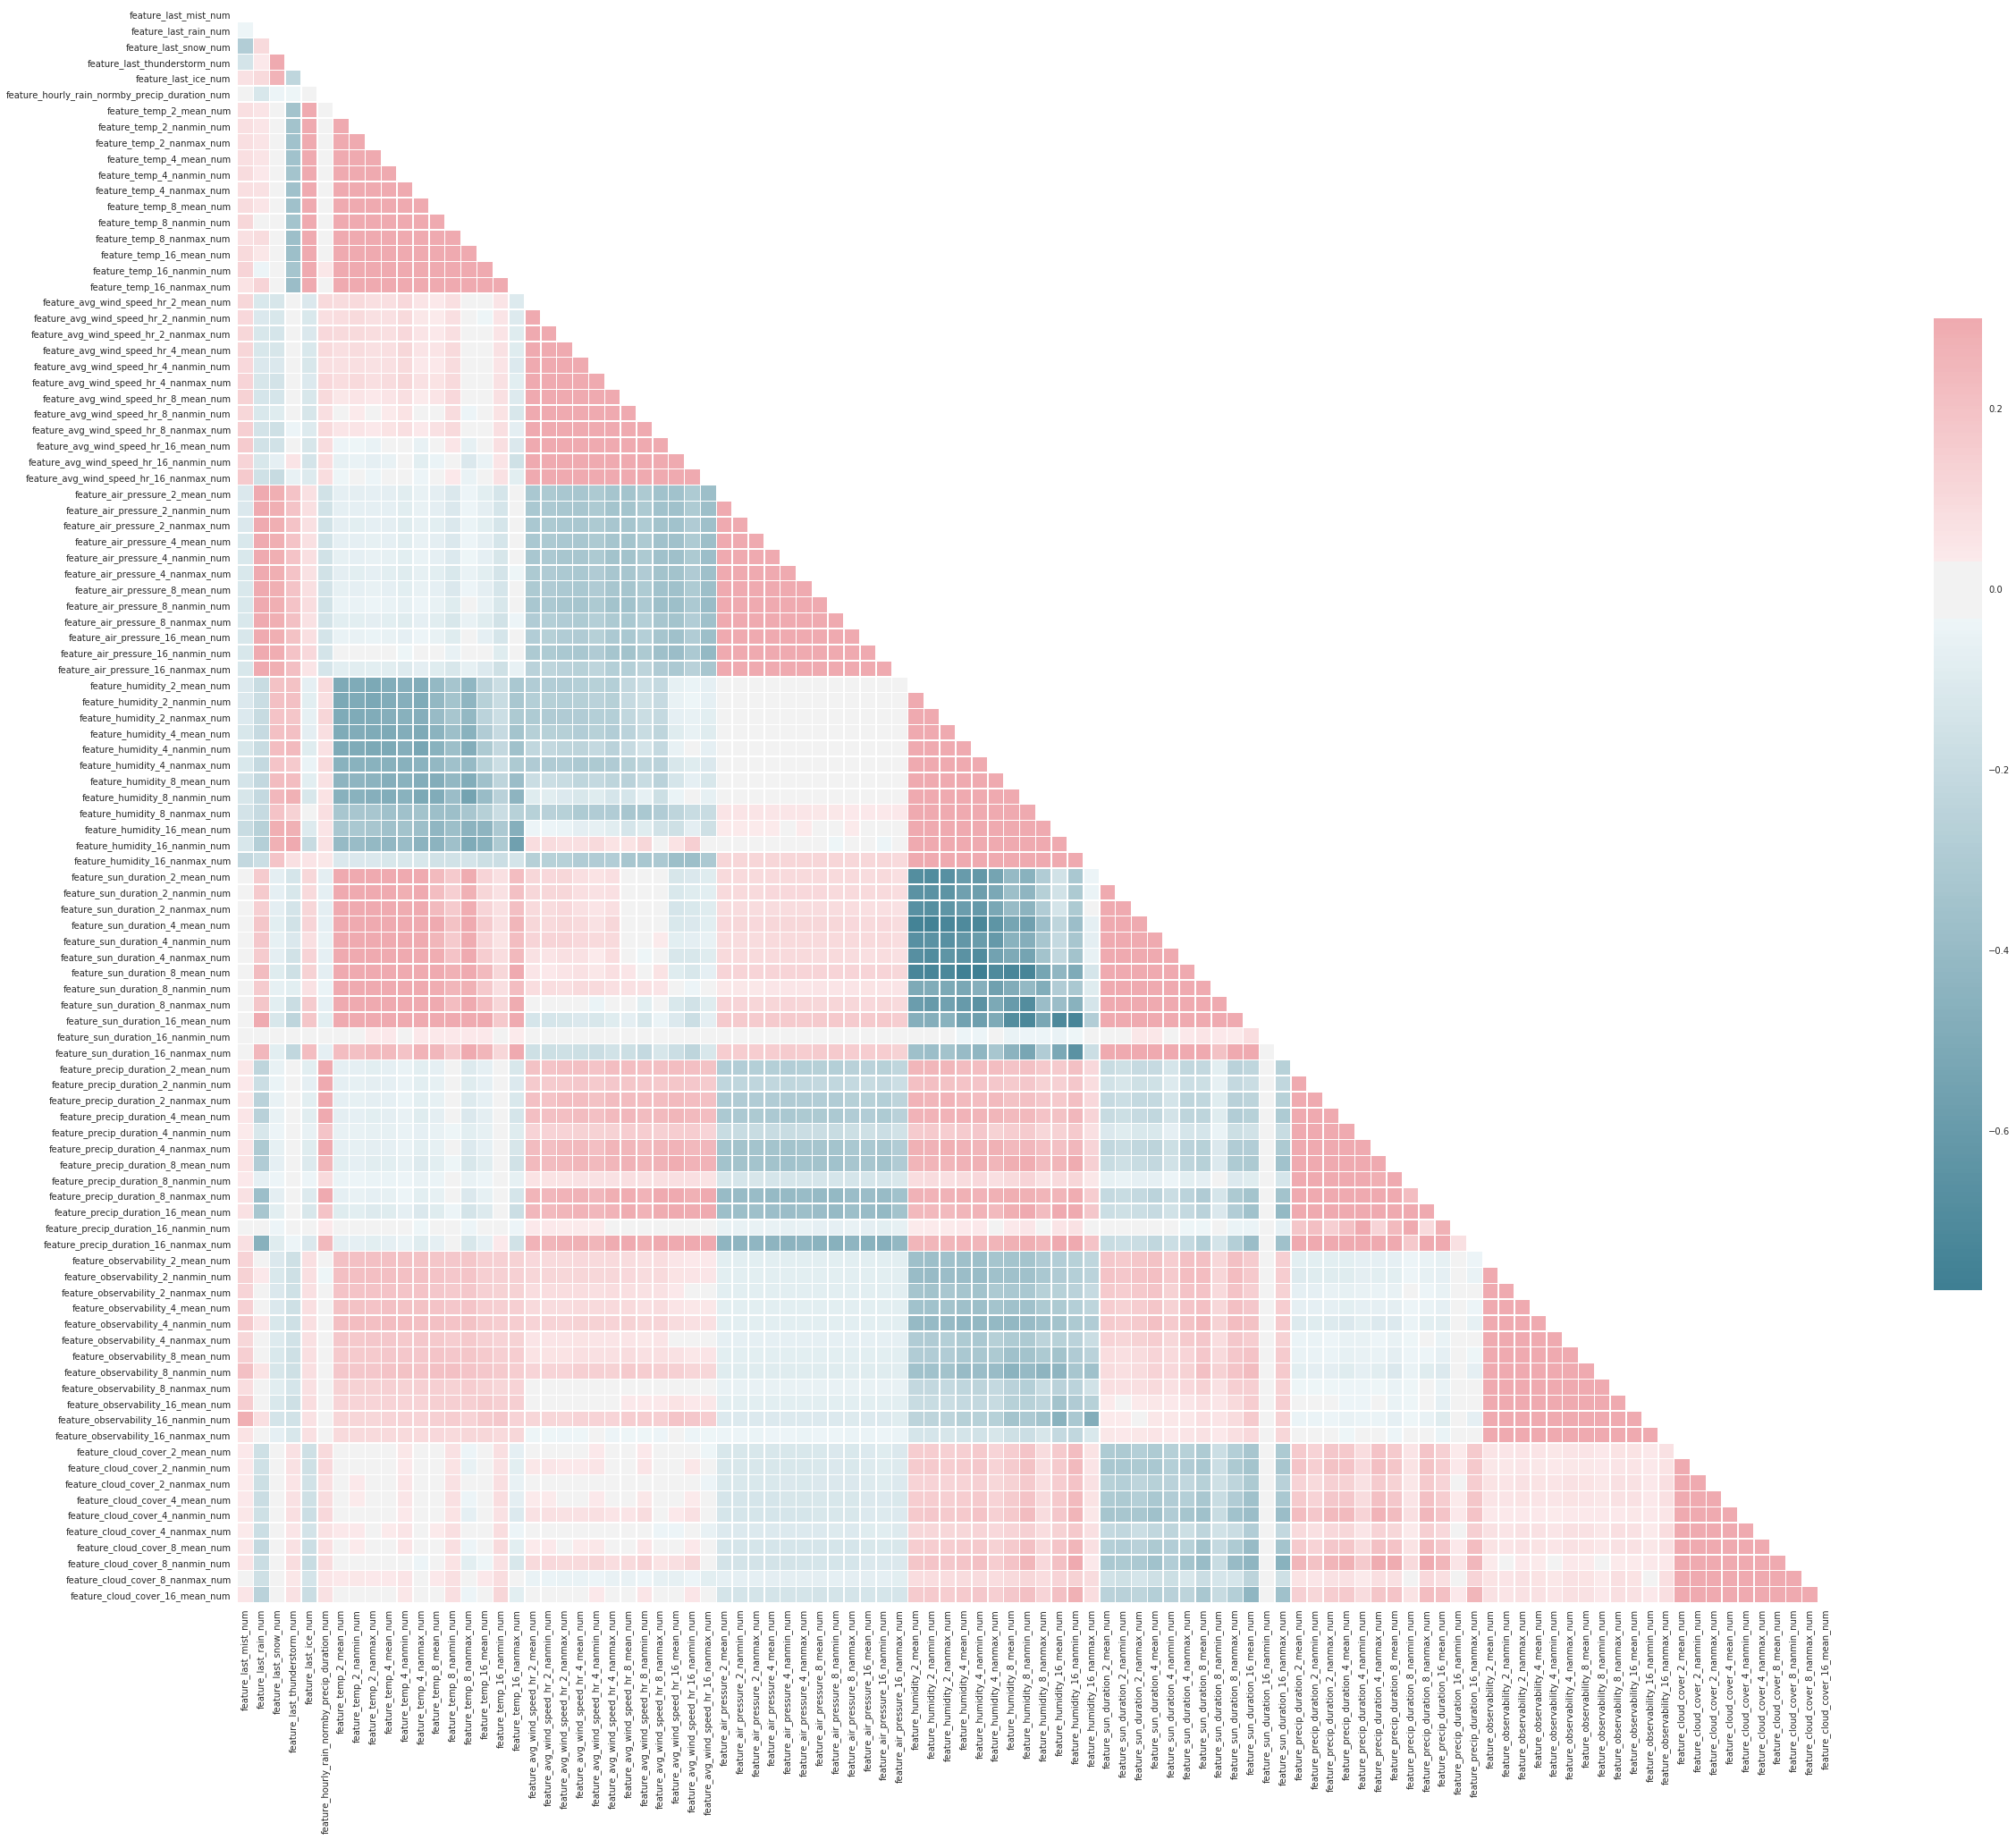

In [8]:

sns.set(style="white")
# Generate a large random dataset
# rs = np.random.RandomState(33)
# d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                  columns=list(ascii_letters[26:]))

# Compute the correlation matrix
#corr = X_train[['flow_avgxlanes_avgseg','flow_avgxlanes_maxseg', 'flow_avgxlanes_minseg','num_lanes_min_mean','num_lanes_max_mean','max_speedlim_day','max_speedlim_night','mean_speedlim_day','mean_speedlim_night','min_speedlim_day','eve_rushhour_True','eve_rushhour_False']].corr()
corr = X_train[X_train.columns[:100]].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 40))
#f, ax = plt.subplots()


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
corr = X_train[X_train.columns[:]].corr()
corr_abs = corr.abs()

unstacked_corr = corr_abs.unstack()
sorted_corr = unstacked_corr.sort_values(kind="quicksort",ascending=False)

In [57]:
#Absolute correlation score
for index, val in sorted_corr[sorted_corr!=1.0][:2000].iteritems():
    print(index,val)

('feature_air_pressure_2_mean_num', 'feature_air_pressure_2_nanmin_num') 0.99982592251887
('feature_air_pressure_2_nanmin_num', 'feature_air_pressure_2_mean_num') 0.99982592251887
('feature_air_pressure_2_mean_num', 'feature_air_pressure_2_nanmax_num') 0.9998239431283222
('feature_air_pressure_2_nanmax_num', 'feature_air_pressure_2_mean_num') 0.9998239431283222
('feature_air_pressure_2_mean_num', 'feature_air_pressure_2_ago_num') 0.9996861994693264
('feature_air_pressure_2_ago_num', 'feature_air_pressure_2_mean_num') 0.9996861994693264
('feature_air_pressure_1_ago_num', 'feature_air_pressure_2_mean_num') 0.99967571530452
('feature_air_pressure_2_mean_num', 'feature_air_pressure_1_ago_num') 0.99967571530452
('feature_air_pressure_2_ago_num', 'feature_air_pressure_4_mean_num') 0.9995707087614263
('feature_air_pressure_4_mean_num', 'feature_air_pressure_2_ago_num') 0.9995707087614263
('feature_air_pressure_4_mean_num', 'feature_air_pressure_3_ago_num') 0.9995406780075762
('feature_air_pre

('feature_avg_wind_speed_hr_4_nanmax_num', 'feature_avg_wind_speed_hr_8_mean_num') 0.9396327998299502
('feature_observability_2_nanmax_num', 'feature_observability_4_nanmin_num') 0.9395488494081117
('feature_observability_4_nanmin_num', 'feature_observability_2_nanmax_num') 0.9395488494081117
('speed_minxlanes_avgxseg_15min_num', 'speed_avgxlanes_avgxseg_15min_num') 0.9395131707107963
('speed_avgxlanes_avgxseg_15min_num', 'speed_minxlanes_avgxseg_15min_num') 0.9395131707107963
('feature_humidity_4_nanmin_num', 'feature_humidity_2_mean_num') 0.9392977857902427
('feature_humidity_2_mean_num', 'feature_humidity_4_nanmin_num') 0.9392977857902427
('feature_temp_4_nanmax_num', 'feature_temp_8_nanmin_num') 0.9391460142180171
('feature_temp_8_nanmin_num', 'feature_temp_4_nanmax_num') 0.9391460142180171
('speed_maxdiffxlanes_avgxseg_1hrmax15min_num', 'speed_maxdiffxlanes_avgxseg_1hravg15min_num') 0.9389978778095149
('speed_maxdiffxlanes_avgxseg_1hravg15min_num', 'speed_maxdiffxlanes_avgxseg_1hr

('flowstd_maxxlanes_maxxseg_1hrmax15min_num', 'flow_avgxlanes_avgxseg_1hrmax15min_num') 0.8097778611837853
('speed_avgxlanes_maxxseg_1hrmin15min_num', 'speed_avgxlanes_avgxseg_15min_num') 0.8092947371685083
('speed_avgxlanes_avgxseg_15min_num', 'speed_avgxlanes_maxxseg_1hrmin15min_num') 0.8092947371685083
('flow_avgxlanes_avgxseg_15min_num', 'flow_maxdiffxlanes_maxxseg_15min_num') 0.8091702527015092
('flow_maxdiffxlanes_maxxseg_15min_num', 'flow_avgxlanes_avgxseg_15min_num') 0.8091702527015092
('accidents_past_8_num', 'accidents_past_4_num') 0.8090132594233078
('accidents_past_4_num', 'accidents_past_8_num') 0.8090132594233078
('speed_minxlanes_avgxseg_1hrmin15min_num', 'speed_avgxlanes_minxseg_15min_num') 0.8088734892763931
('speed_avgxlanes_minxseg_15min_num', 'speed_minxlanes_avgxseg_1hrmin15min_num') 0.8088734892763931
('speedstd_avgxlanes_maxxseg_1hrmax15min_num', 'speedstd_avgxlanes_maxxseg_15min_num') 0.8085962126514944
('speedstd_avgxlanes_maxxseg_15min_num', 'speedstd_avgxlane

In [58]:
#Absolute correlation score
blacklist = list()
for index, val in sorted_corr[ sorted_corr>corr_thres ].iteritems():
    if (index[0]!=index[1]):
        if index[0] not in blacklist and index[1] not in blacklist:
            blacklist.append(index[1])
        elif bool(index[0] not in blacklist) != bool(index[1] not in blacklist) :#XOR
            pass
print(blacklist)

['exit_type_mode_cat_PseudoHalfklaverbladaansluiting', 'includes_road_number_2_cat_True', 'entrance_type_mode_cat_Tknooppunt', 'speed_avgxlanes_avgxseg_1hrmax15min_num', 'tilt_avgxseg_num', 'feature_air_pressure_2_nanmin_num', 'feature_air_pressure_2_nanmax_num', 'feature_air_pressure_2_ago_num', 'feature_air_pressure_2_mean_num', 'feature_air_pressure_3_ago_num', 'curvature_avgxseg_num', 'feature_air_pressure_8_mean_num', 'feature_air_pressure_4_nanmin_num', 'feature_air_pressure_4_nanmax_num', 'feature_temp_2_mean_num', 'feature_air_pressure_4_mean_num', 'curvature_minxseg_num', 'min_number_lanes_avgxseg_num', 'feature_temp_4_mean_num', 'feature_temp_1_ago_num', 'feature_temp_2_nanmin_num', 'feature_temp_2_ago_num', 'feature_air_pressure_8_nanmin_num', 'feature_air_pressure_8_nanmax_num', 'flow_totalxlanes_totalxseg_1hrmax15min_num', 'feature_humidity_2_nanmin_num', 'feature_observability_2_nanmax_num', 'feature_observability_2_mean_num', 'feature_air_pressure_1_ago_num', 'feature_te

In [60]:
#Trim out highly correlated features
X_train = X_train.drop(blacklist,errors='ignore', axis=1)

In [61]:
X_train.shape

(101200, 270)

# PCA

explained variance ratio (first two components): [0.10635657 0.07330404]


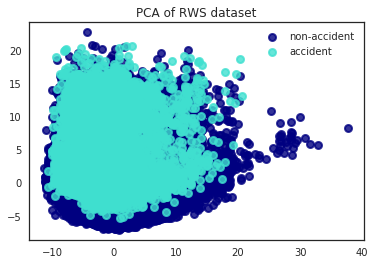

In [13]:
from sklearn.decomposition import PCA

X = X_train
y = y_train
target_names = ['non-accident','accident']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)


# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


colors = ['navy', 'turquoise']
lw = 2
plt.figure()
for color, i, target_name in zip(colors, [0, 1], target_names):

    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of RWS dataset')


plt.show()

In [79]:
#PC0
order = pca.components_[0].argsort()
for i in order[::-1][:20]:
    print(X_train.columns[i])

feature_precip_duration_8_mean_num
feature_precip_duration_4_nanmax_num
feature_precip_duration_8_nanmax_num
feature_precip_duration_16_mean_num
feature_precip_duration_2_ago_num
feature_precip_duration_16_nanmax_num
feature_humidity_8_nanmin_num
feature_precip_duration_3_ago_num
feature_precip_duration_1_ago_num
feature_humidity_1_ago_num
feature_precip_duration_2_nanmin_num
feature_humidity_4_nanmax_num
feature_precip_duration_4_ago_num
feature_humidity_16_nanmin_num
feature_hourly_rain_16_mean_num
feature_precip_duration_4_nanmin_num
feature_cloud_cover_8_nanmin_num
feature_humidity_16_mean_num
feature_hourly_rain_4_nanmax_num
feature_cloud_cover_16_nanmin_num


In [80]:
#PC1
order = pca.components_[1].argsort()
for i in order[::-1][:20]:
    print(X_train.columns[i])

feature_sun_duration_8_mean_num
feature_sun_duration_3_ago_num
feature_sun_duration_4_ago_num
feature_avg_wind_speed_hr_4_ago_num
feature_sun_duration_4_nanmin_num
feature_hourly_rain_4_nanmax_num
feature_sun_duration_2_ago_num
feature_sun_duration_4_nanmax_num
feature_precip_duration_2_nanmin_num
feature_precip_duration_2_ago_num
feature_precip_duration_8_mean_num
feature_avg_wind_speed_hr_1_ago_num
feature_precip_duration_4_nanmax_num
feature_hourly_rain_2_nanmax_num
feature_hourly_rain_16_mean_num
feature_precip_duration_1_ago_num
feature_precip_duration_4_nanmin_num
feature_avg_wind_speed_hr_8_nanmin_num
feature_precip_duration_3_ago_num
feature_sun_duration_8_nanmin_num


# Feature importances with RF and LR

In [62]:
rf = RandomForestClassifier(max_depth=10,max_features='sqrt',min_samples_split=10,n_estimators=300, random_state=42)
rf.fit(X_train,y_train)
# lr = LogisticRegression(C=0.001, penalty="l1")
# lr.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Random Forest

In [63]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [64]:
experiment.FEATURES_TEMPORAL_LIST

['day_of_week_cat',
 'eve_rushhour_cat',
 'hour_cat',
 'month_cat',
 'morn_rushhour_cat',
 'rushhour_cat',
 'week_of_year_cat',
 'weekend_cat']

In [65]:
# Print the feature ranking
print("Feature ranking:")
rf_feat_rank = []
for f in range(X_train.shape[1]):
    print("%d. %s" % (f + 1, X_train.columns[indices[f]]))
    rf_feat_rank.append(X_train.columns[indices[f]])

Feature ranking:
1. accidents_past_16_num
2. speed_minxlanes_minxseg_15min_num
3. accidents_past_1_num
4. speed_avgxlanes_diffprevrec_avgxseg_1hravg15min_num
5. speedstd_maxxlanes_maxxseg_1hrmax15min_num
6. speed_avgxlanes_maxxseg_1hravg15min_num
7. speed_avgxlanes_diffloopbehind_maxxseg_15min_num
8. flowstd_avgxlanes_avgxseg_15min_num
9. speed_avgxlanes_diffloopbehind_avgxseg_1hrmax15min_num
10. flow_totalxlanes_diffprevrec_maxxseg_1hravg15min_num
11. flow_totalxlanes_maxdiffxseg_15min_num
12. speed_avgxlanes_diffloopahead_maxxseg_15min_num
13. speed_avgxlanes_diffprevrec_maxxseg_15min_num
14. flow_totalxlanes_totalxseg_1hrmin15min_num
15. flow_totalxlanes_totalxseg_maxdiffx1hr_num
16. feature_last_snow_num
17. speed_avgxlanes_diffloopahead_avgxseg_1hravg15min_num
18. flow_totalxlanes_diffprevrec_maxxseg_15min_num
19. speed_avgxlanes_diffprevrec_avgxseg_15min_num
20. speed_avgxlanes_diffprevrec_avgxseg_1hrmax15min_num
21. flow_totalxlanes_diffprevrec_avgxseg_1hravg15min_num
22. rushho

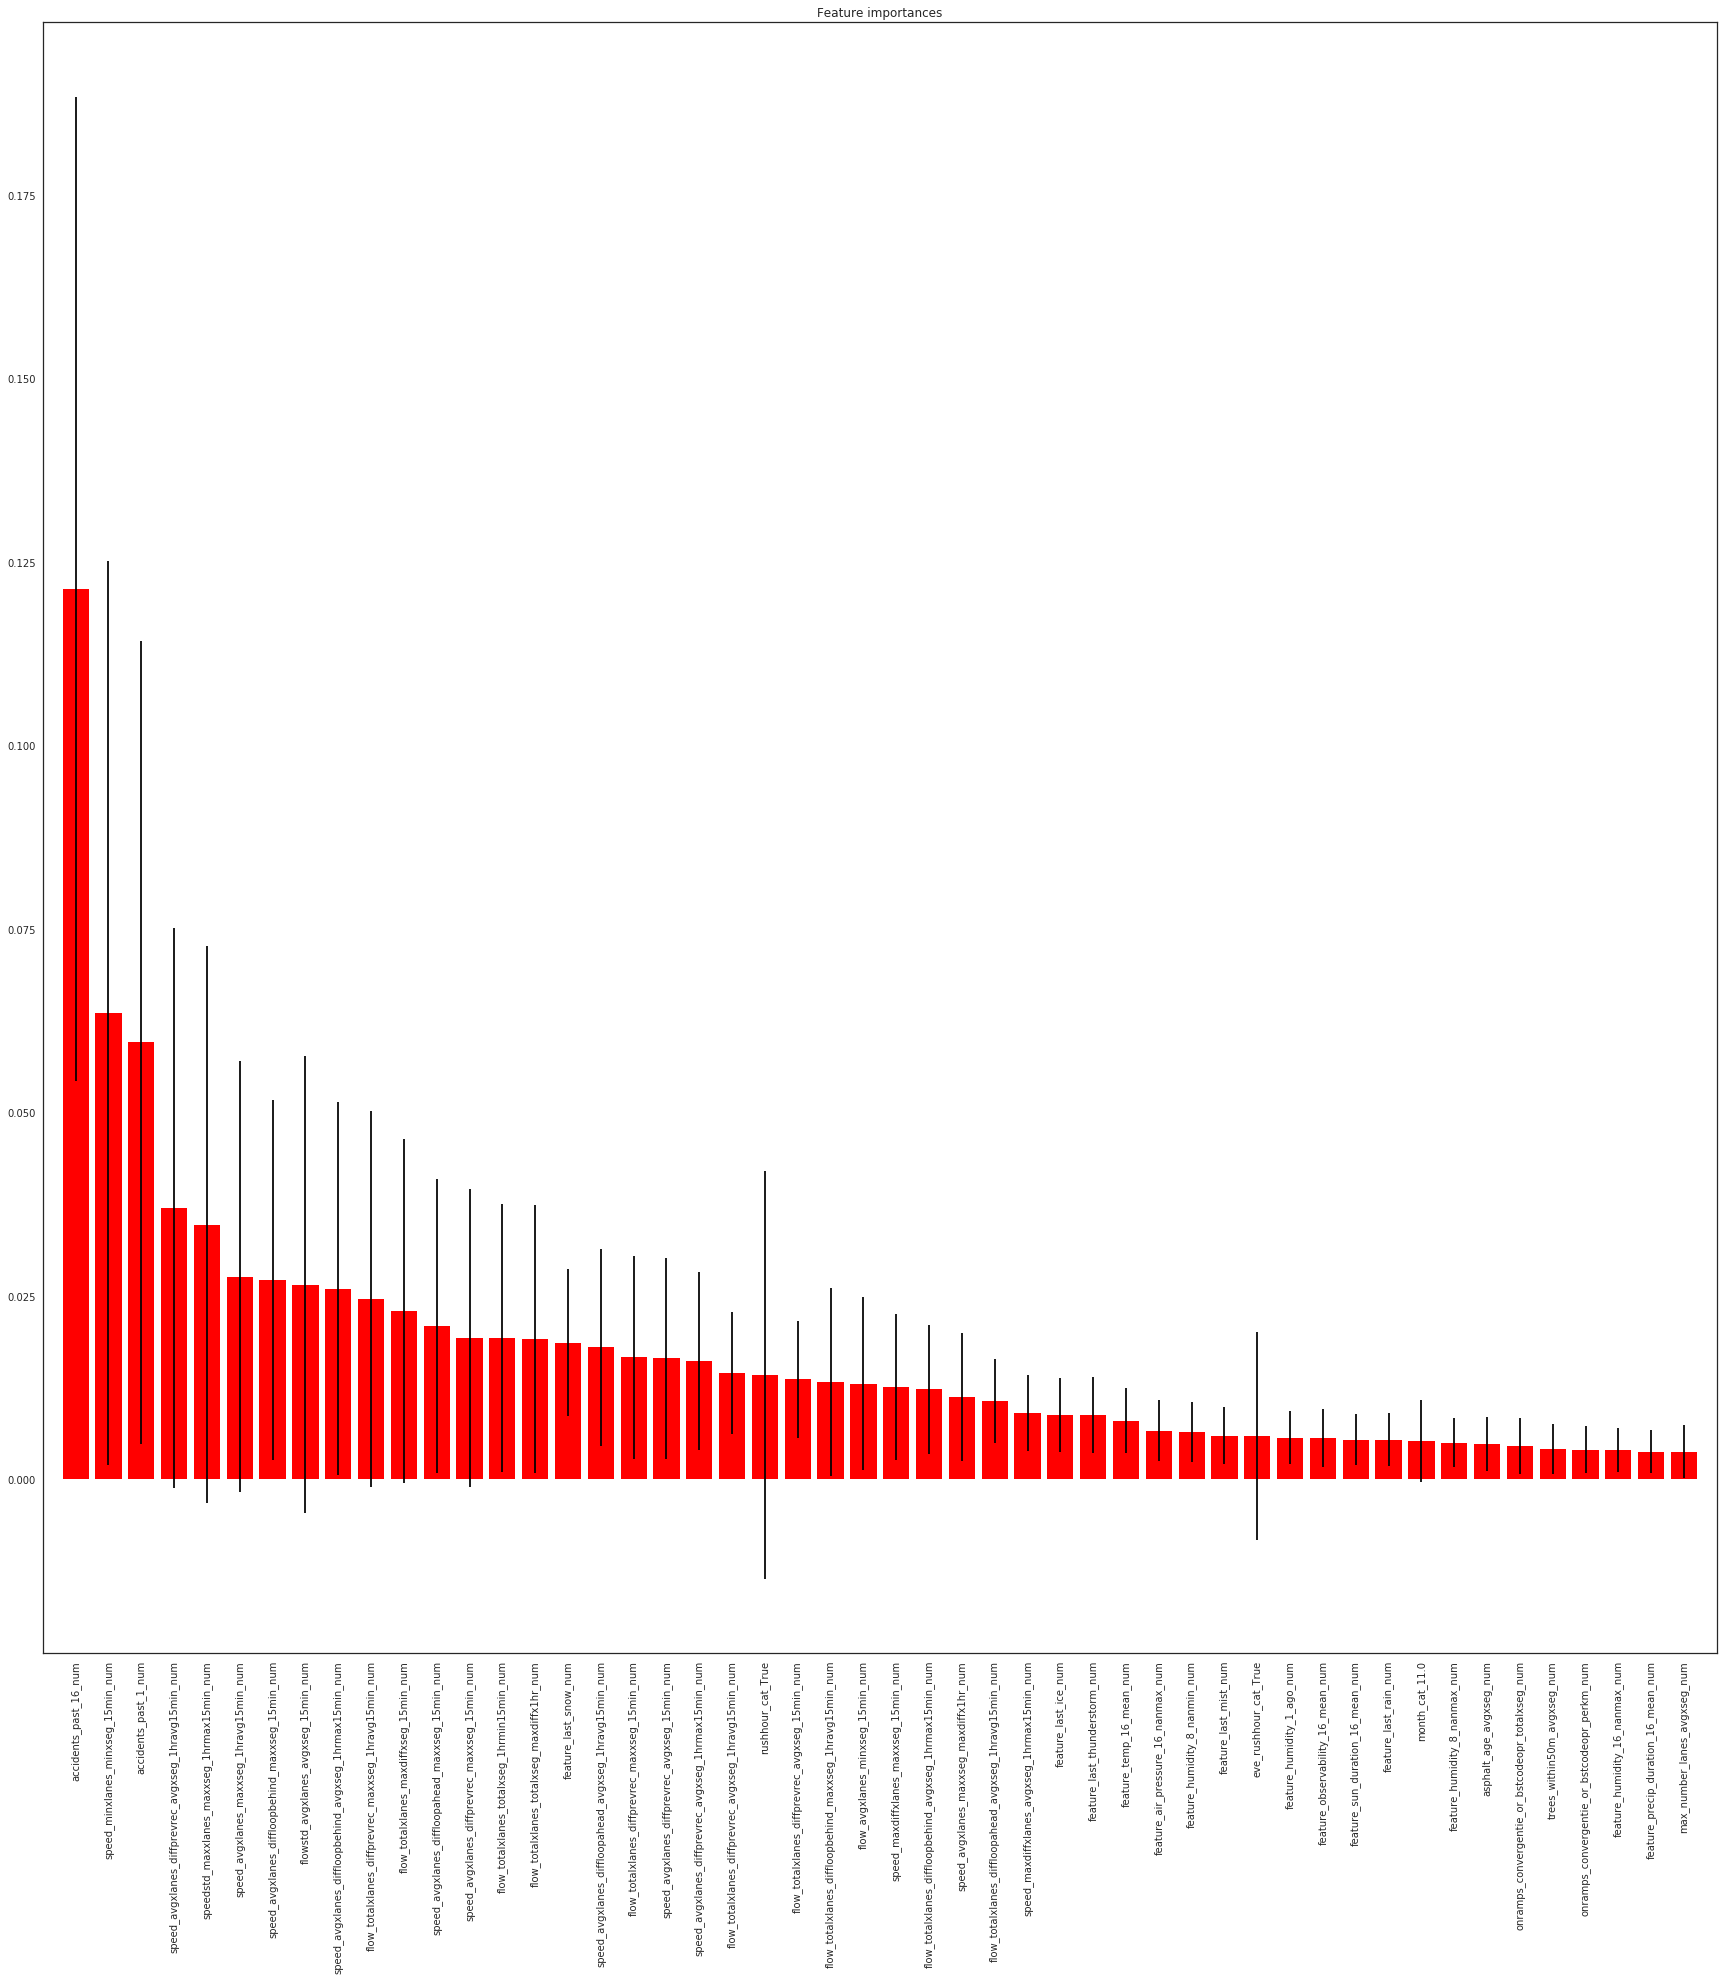

In [68]:
# Plot the feature importances (top 50)
plt.figure(figsize=(30, 30))
plt.title("Feature importances")
plt.bar(range(50), importances[indices][:50],
       color="r", yerr=std[indices][:50], align="center")
plt.xticks(range(50), X_train.columns[indices[:50]],rotation=90)

plt.xlim([-1, 50])
plt.show()

In [67]:
X_train.shape[1]

270

# Feature YAML LIST
Top k features

In [69]:
import re
top_dict= {'features_knmi_config': 
                  {'table_name':'features_knmi_agg.knmi_feature_master_v7',
                   'time_granularity_min':60,
                   'use_all_features':False,
                   'features_list':list(),
                   'meta_columns': ['datetime','weather_station']
                  },
           'features_flow_config': 
                  {'table_name':'features_speedflow_agg.fifteenmin_seg_ten_km_v1',
                   'time_granularity_min':15,
                   'space_granularity_km': 10,
                   'use_all_features':False,
                   'features_list':list(),
                   'meta_columns': ['end_datetime','hectokey_merged']
                  },
           'features_hectopunten_config': 
                  {'table_name':'features_hectopunten_agg.hectopunten_ten_km_v12',
                   'space_granularity_km': 10,
                   'use_all_features':False,
                   'features_list':list(),
                   'meta_columns': ['hectokey_merged','rollup_year','weather_station']
                  },
           'features_ongevallen_config': 
                  {'table_name':'features_ongevallen_agg.ongevallen_feature_ten_km_thirty_min',
                   'time_granularity_min':30,
                   'space_granularity_km': 10,
                   'use_all_features':False,
                   'features_list':list(),
                   'meta_columns': ['datetime','hectokey_merged']
                  },
           'features_temporal_config': 
                  {'table_name':'features_temporal_agg.temporal_feature_60min_v3',
                   'time_granularity_min':60,
                   'use_all_features':False,
                   'features_list':list(),
                   'meta_columns': ['datetime']
                  }
          }

In [70]:
cat_rex = re.compile(r'^.*_cat')
#top_dict = {experiment.FEATURES_KNMI_TABLE:[],experiment.FEATURES_FLOW_TABLE:[],experiment.FEATURES_HECTOPUNTEN_TABLE:[],experiment.FEATURES_TEMPORAL_TABLE:[]}
for col in rf_feat_rank[:k_features]:
    if bool(cat_rex.match(col)):
        col=cat_rex.match(col).group()
    if col in experiment.FEATURES_KNMI_LIST:
        if col not in top_dict['features_knmi_config']['features_list']:
            top_dict['features_knmi_config']['features_list'].append(col)
            print(col,experiment.FEATURES_KNMI_TABLE)
        
    elif col in experiment.FEATURES_FLOW_LIST:
        if col not in top_dict['features_flow_config']['features_list']:
            top_dict['features_flow_config']['features_list'].append(col)
            print(col,experiment.FEATURES_FLOW_TABLE)

    elif col in experiment.FEATURES_HECTOPUNTEN_LIST:
        if col not in top_dict['features_hectopunten_config']['features_list']:
            top_dict['features_hectopunten_config']['features_list'].append(col)
            print(col,experiment.FEATURES_HECTOPUNTEN_TABLE)
        
    elif col in experiment.FEATURES_TEMPORAL_LIST:
        if col not in top_dict['features_temporal_config']['features_list']:
            top_dict['features_temporal_config']['features_list'].append(col)
            print(col,experiment.FEATURES_TEMPORAL_TABLE)
            
    elif col in experiment.FEATURES_ONGEVALLEN_LIST:
        if col not in top_dict['features_ongevallen_config']['features_list']:
            top_dict['features_ongevallen_config']['features_list'].append(col)
            print(col,experiment.FEATURES_ONGEVALLEN_TABLE)


accidents_past_16_num features_ongevallen_agg.ongevallen_feature_ten_km_thirty_min
speed_minxlanes_minxseg_15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
accidents_past_1_num features_ongevallen_agg.ongevallen_feature_ten_km_thirty_min
speed_avgxlanes_diffprevrec_avgxseg_1hravg15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
speedstd_maxxlanes_maxxseg_1hrmax15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
speed_avgxlanes_maxxseg_1hravg15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
speed_avgxlanes_diffloopbehind_maxxseg_15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
flowstd_avgxlanes_avgxseg_15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
speed_avgxlanes_diffloopbehind_avgxseg_1hrmax15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
flow_totalxlanes_diffprevrec_maxxseg_1hravg15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
flow_totalxlanes_maxdiffxseg_15min_num features_speedflow_agg.fifteenmin_seg_ten_km_v1
sp

In [3]:
import sys
import yaml

In [ ]:
yaml.dump(top_dict, sys.stdout,default_flow_style=False)

In [54]:

with open(f'feature_config_{k_features}.yaml', 'w') as outfile:
    yaml.dump(top_dict, outfile, default_flow_style=False)

# Generate a list of all features 
Change "table_name" to refer to correct feature tables

In [4]:
all_dict= {'features_knmi_config': 
                  {'table_name':'features_knmi_agg.knmi_feature_master_v7',
                   'time_granularity_min':60,
                   'use_all_features':True,
                   'meta_columns': ['datetime','weather_station']
                  },
           'features_flow_config': 
                  {'table_name':'features_speedflow_agg.fifteenmin_seg_ten_km_v1',
                   'time_granularity_min':15,
                   'space_granularity_km': 10,
                   'use_all_features':True,
                   'meta_columns': ['end_datetime','hectokey_merged']
                  },
           'features_hectopunten_config': 
                  {'table_name':'features_hectopunten_agg.hectopunten_ten_km_v12',
                   'space_granularity_km': 10,
                   'use_all_features':True,

                   'meta_columns': ['hectokey_merged','rollup_year','weather_station']
                  },
           'features_ongevallen_config': 
                  {'table_name':'features_ongevallen_agg.ongevallen_feature_ten_km_thirty_min',
                   'time_granularity_min':30,
                   'space_granularity_km': 10,
                   'use_all_features':True,
                   'meta_columns': ['datetime','hectokey_merged']
                  },
           'features_temporal_config': 
                  {'table_name':'features_temporal_agg.temporal_feature_60min_v3',
                   'time_granularity_min':60,
                   'use_all_features':True,
                   'meta_columns': ['datetime']
                  }
          }

with open(f'feature_config_all.yaml', 'w') as outfile:
    yaml.dump(all_dict, outfile, default_flow_style=False)